In [90]:
# Results and Visualizations for Rasch Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
# Returns dataframe df with just rows with 'question_id' == num
def exam_num_df(num, df):
    # Applies lambda function searching for rows (axis=1) with 'question_id' = num
    exam_mask = df.apply(lambda x: x['question_id'].startswith(num), axis=1) 
    exam_df = df[exam_mask]
    return exam_df

def exam_ver_df(num, ver, df):
    # Applies lambda function searching for rows (axis=1) with 'question_id' = num
    exam_mask = df.apply(lambda x: x['question_id'].startswith(f'{num}{ver}'), axis=1) 
    exam_df = df[exam_mask]
    return exam_df

# Item Results

In [3]:
rasch_items_df = pd.read_excel('../item_summary.xlsx')

## Item Difficulty Distributions (ignore)

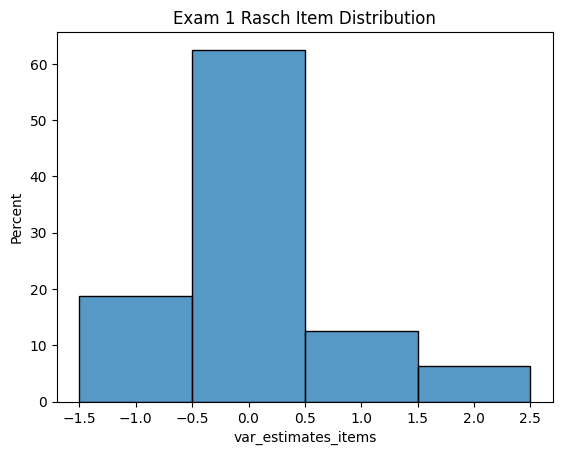

In [13]:
plt.clf()
ax = sb.histplot(data=exam_1_rasch_items['var_estimates_items'].dropna().astype(int), bins=4, discrete=True, stat='percent')
ax.set_title(f'Exam 1 Rasch Item Distribution')
#ax.set(xticks=5, yticks=range(0, 50, 5))
plt.savefig(f'../figures/rasch_item_distribution.jpg')

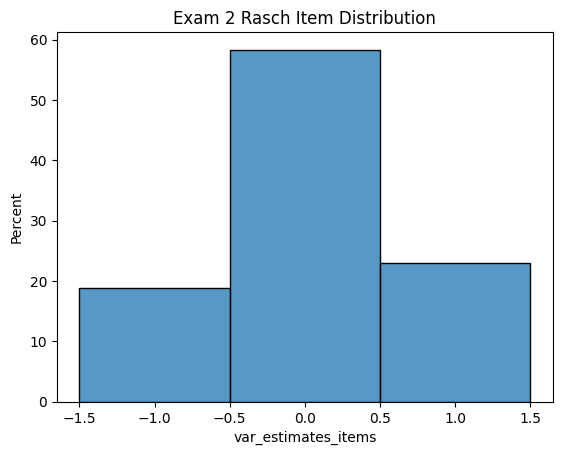

In [14]:
plt.clf()
ax = sb.histplot(data=exam_2_rasch_items['var_estimates_items'].dropna().astype(int), bins=4, discrete=True, stat='percent')
ax.set_title(f'Exam 2 Rasch Item Distribution')
#ax.set(xticks=5, yticks=range(0, 50, 5))
plt.savefig(f'../figures/rasch_item_distribution.jpg')

## Fit Results

In [52]:
def create_fit_dict(fit_type, df):
    fit_dict = {}
    for exam_num in range(1, 5):
        if exam_num == 1:
            ver_list = ['A', 'B']
        else: 
            ver_list = ['A', 'B', 'C']
        for exam_ver in ver_list:
            temp_df = exam_ver_df(exam_num, exam_ver, df)
            fit_dict[f'{exam_num}{exam_ver}'] = {
                'Good': 100*temp_df[f'is_good_{fit_type}'].sum()/len(temp_df[f'is_good_{fit_type}']),
                'Acceptable': 100*temp_df[f'is_acceptable_{fit_type}'].sum()/len(temp_df[f'is_acceptable_{fit_type}']),
                'Poor': 100*temp_df[f'is_poor_{fit_type}'].sum()/len(temp_df[f'is_poor_{fit_type}'])
            }
    return fit_dict

def add_fit_subplot(df, exam_keys, fit_type, axis, title):
    fit_dict = create_fit_dict(fit_type, df)
    labels = ["Poor", "Acceptable", "Good"]
    text_color = ["black", "black", "white"]
    bar_bottoms = [0, 0, 0]
    bar_count = 0
    for key in exam_keys:
        exam_bar_data = []
        for temp_label in labels:
            exam_bar_data.append(fit_dict[key][temp_label])
        axis.bar(labels, exam_bar_data, label=key, bottom = bar_bottoms)
        
        
        for i in range(len(bar_bottoms)):
            bar_bottoms[i] += exam_bar_data[i]
        for j in range(len(exam_bar_data)):
            y_position = (bar_bottoms[j] - exam_bar_data[j]/2)
            if exam_bar_data[j] >= 25:
                axis.text(labels[j], y_position, f"{exam_bar_data[j]:.2f}", color = text_color[bar_count], ha='center', va='bottom', fontsize = 10)
        bar_count += 1
    
    axis.legend(prop={'size': 10})
    axis.set_xlabel(f"{fit_type} categories")
    axis.set_ylabel("Percent of fit")
    axis.set_title(title)
    custom_palette = ['#cf4456', '#f29566', '#831c64']
    plt.rcParams['axes.prop_cycle'] = plt.cycler('color', custom_palette)

def save_fit_plots(fit_type, filename):
    fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(10,6))

    add_fit_subplot(df=rasch_items_df, axis=ax0, exam_keys=["1A", "1B"], title="Exam 1", fit_type=fit_type)
    add_fit_subplot(df=rasch_items_df, axis=ax1, exam_keys=["2A", "2B", "2C"], title="Exam 2", fit_type=fit_type)
    add_fit_subplot(df=rasch_items_df, axis=ax2, exam_keys=["3A", "3B", "3C"], title="Exam 3", fit_type=fit_type)
    add_fit_subplot(df=rasch_items_df, axis=ax3, exam_keys=["4A", "4B", "4C"], title="Exam 4", fit_type=fit_type)

    fig.tight_layout()
    
    plt.savefig(f"../figures/{filename}")
    plt.close(fig)

### Infit

In [53]:
save_fit_plots('infit', 'infit_plots.png')

### Outfit

In [51]:
save_fit_plots('outfit', 'outfit_plots.png')

In [4]:
good_outfit_df = rasch_items_df[rasch_items_df['is_good_outfit'] == 1]
poor_outfit_df = rasch_items_df[rasch_items_df['is_poor_outfit'] == 1]

In [99]:
def graph_scatterplot(df, col_1, col_2):
    sb.scatterplot(df[[col_1, col_2]].set_index(col_1))

def calc_corr(df, fit_type, col_2):
    temp_df = df[[f'{fit_type}_items', col_2]]
    return round(temp_df.corr().loc[f'{fit_type}_items', col_2], 2)

def calc_log_corr(df, fit_type, col_2):
    temp_df = df[[f'{fit_type}_items', col_2]]
    temp_df = temp_df.apply(np.log)
    return round(temp_df.corr().loc[f'{fit_type}_items', col_2], 2)

def calc_both_corr(df, fit_type, col_2):
    reg_corr = calc_corr(df, fit_type, col_2)
    log_corr = calc_log_corr(df, fit_type, col_2)
    return f'{reg_corr}, {log_corr}'

def extract_scatter_lists(df, col_1, col_2):
    x_vals = df[[col_1]][col_1].to_list()
    y_vals = df[[col_2]][col_2].to_list()
    return {'x_vals': x_vals, 'y_vals': y_vals}

def add_fit_sub_scatterplot(df, col_to_compare, fit_type, axis, title):
    vals_dict = extract_scatter_lists(df, f'{fit_type}_items', col_to_compare)
    axis.scatter(vals_dict['x_vals'], vals_dict['y_vals'])

    axis.set_xlabel(f"{fit_type} Items")
    axis.set_ylabel(col_to_compare)
    axis.set_title(title)

    custom_palette = ['#cf4456']
    plt.rcParams['axes.prop_cycle'] = plt.cycler('color', custom_palette)

def save_fit_scatterplots(fit_type, filename):
    fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(10,6))

    good_df = rasch_items_df[rasch_items_df[f'is_good_{fit_type}'] == 1]
    col_0 = 'var_estimates_items'
    add_fit_sub_scatterplot(good_df, 
                            col_0, 
                            fit_type, 
                            ax0, 
                            f'Good Outfit - Corr = {calc_both_corr(good_df, fit_type, col_0)}')
    col_1 = 'pbc'
    add_fit_sub_scatterplot(good_df, 
                            col_1, 
                            fit_type, 
                            ax1, 
                            f'Good Outfit - Corr = {calc_both_corr(good_df, fit_type, col_1)}')
    
    poor_df = rasch_items_df[rasch_items_df[f'is_poor_{fit_type}'] == 1]
    add_fit_sub_scatterplot(poor_df, 
                            col_0, 
                            fit_type, 
                            ax2, 
                            f'Poor Outfit - Corr = {calc_both_corr(poor_df, fit_type, col_0)}')
    add_fit_sub_scatterplot(poor_df, 
                            col_1, 
                            fit_type, 
                            ax3, 
                            f'Poor Outfit - Corr = {calc_both_corr(poor_df, fit_type, col_1)}')
    
    fig.tight_layout()
    
    plt.savefig(f"../figures/{filename}")
    plt.close(fig)

In [100]:
save_fit_scatterplots('outfit', 'scatterplots_outfit_vs_difficulty_and_pbc.png')

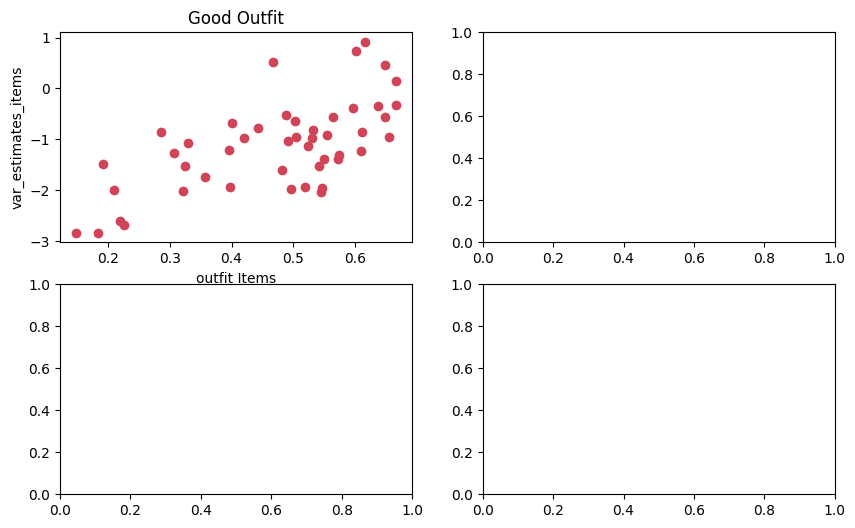

In [75]:
fit_type = 'outfit'
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(10,6))
add_fit_sub_scatterplot(rasch_items_df[rasch_items_df[f'is_good_{fit_type}'] == 1], 
                            'var_estimates_items', 
                            fit_type, 
                            ax0, 
                            'Good Outfit')

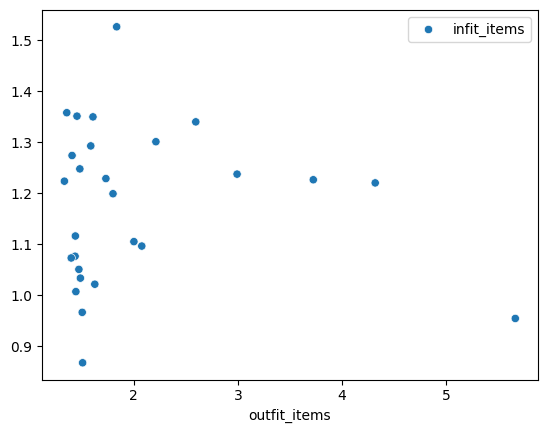

In [23]:
graph_scatterplot(poor_outfit_df, 'outfit_items', 'infit_items')

# Student Results (ignore)

In [15]:
student_df = pd.read_excel("../student_summary.xlsx")

In [16]:
student_df

,student_id,var_estimates_students,outfit_students,infit_students,student_exam_score,is_outfit_outlier,is_infit_outlier
0,987111,1.547781,0.651059,0.818493,0.7600,0,0
1,227374,0.613635,0.509781,0.716360,0.6400,0,0
2,202448,2.378672,0.178145,0.386157,0.8400,0,0
3,184893,-1.132851,11.539026,1.775552,0.3600,1,1
4,136667,1.932840,3.230206,0.707790,0.8000,1,0
...,...,...,...,...,...,...,...
881,108243,1.370766,1.245384,1.315228,0.7500,0,1
882,766288,2.421065,1.603936,1.408019,0.8750,1,1
883,449664,1.836415,0.933786,1.069588,0.8125,0,0
884,988426,0.613169,0.626930,0.742211,0.6250,0,0


<Axes: xlabel='var_estimates_students', ylabel='student_exam_score'>

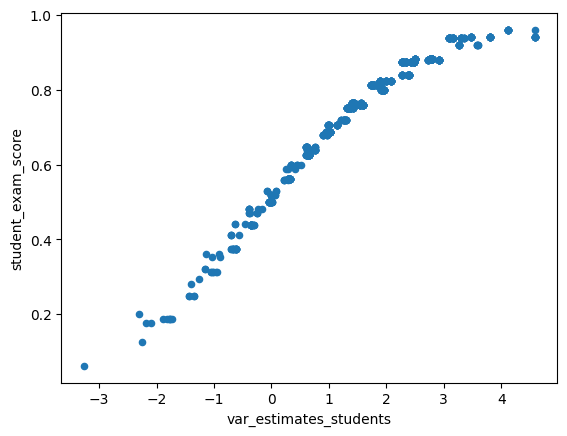

In [18]:
student_df.plot.scatter('var_estimates_students', 'student_exam_score')

In [19]:
student_df[['var_estimates_students', 'student_exam_score']].corr()

,var_estimates_students,student_exam_score
var_estimates_students,1.000000,0.967683
student_exam_score,0.967683,1.000000
